In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from scipy import ndimage
from PIL import Image


# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

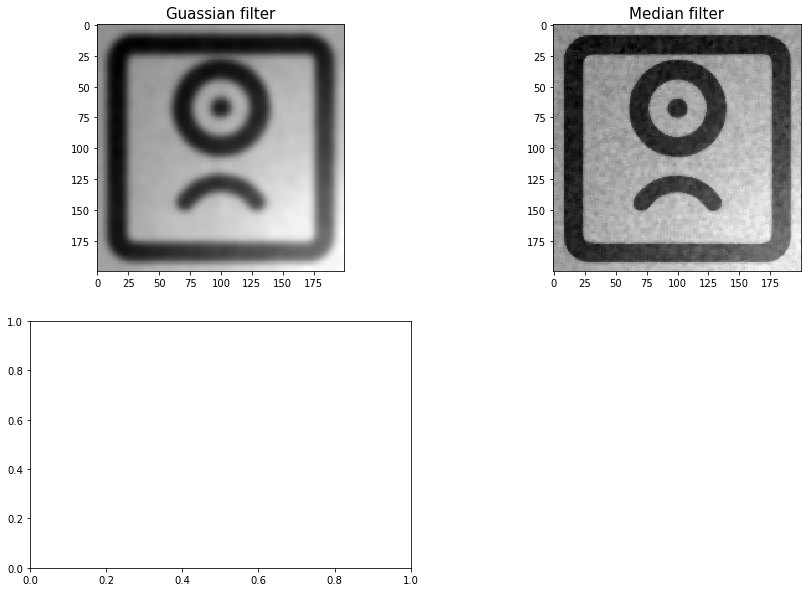

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as img
from scipy import ndimage as nimg 
import numpy as np
imgg = img.imread('/Users/nadira/Desktop/data2/Head/2755.png')
flt = ndimage.median_filter(imgg, 4)
blurred_f = ndimage.gaussian_filter(imgg, 3)
filter_blurred_l = ndimage.gaussian_filter(blurred_f, 1)
alpha = 15
sharpened = blurred_f + alpha * (blurred_f - filter_blurred_l)
fig = plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.imshow(blurred_f, cmap='gray')
plt.title("Guassian filter", fontsize=15)
plt.subplot(222)
plt.imshow(flt, cmap='gray')
plt.title("Median filter", fontsize=15)
plt.subplot(223)

/Users/nadira/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log2
  from ipykernel import kernelapp as app


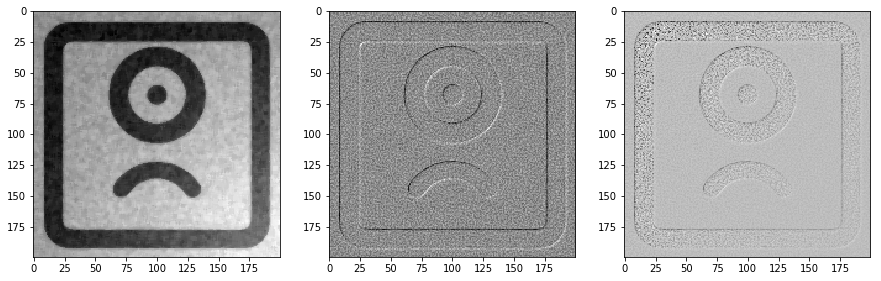

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as img
from scipy import ndimage as nimg 
import numpy as np
arms = img.imread('/Users/nadira/Desktop/data2/Head/2755.png')
gflt = nimg.median_filter(arms, 4)
fig = plt.figure(figsize=(15, 10))
plt.subplot(131)
plt.imshow(gflt, cmap='gray')
plt.subplot(132)
plt.imshow(arms, cmap = 'gray')
plt.imshow((arms-gflt), cmap = 'gray')
maxValue = (arms - gflt).max()
minValue = (arms - gflt).min()
diff = np.log2(arms) - np.log2(gflt)
newImage = (diff-minValue)/(maxValue-minValue)


plt.subplot(133)
plt.imshow(newImage, cmap='gray')
plt.show()

In [9]:
image_size = 50 # Pixel width and height.
size = image_size,image_size
pixel_depth = 255.0 # Number of levels per pixel.
sizes = [784,622,222,473]
folders = [
    '/Users/nadira/Desktop/data2/Arms/',
    '/Users/nadira/Desktop/data2/Figure_normal_legs/',
    '/Users/nadira/Desktop/data2/FigureWheels/',
    '/Users/nadira/Desktop/data2/Head/',
]

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      img = Image.open(image_file)
      newImg = img.resize(size, Image.ANTIALIAS)
      image_data = (np.array(newImg).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset

X_datasets = list()
print(X_datasets)
Y_datasets = list()
for idx in range(len(folders)):
    folder = folders[idx] 
    X_datasets.append(load_letter(folder, sizes[idx]))
    labels = np.zeros((X_datasets[-1].shape[0],len(folders)))
    labels[:,idx] = 1
    Y_datasets.append(labels)
    

[]
/Users/nadira/Desktop/data2/Arms/
Full dataset tensor: (784, 50, 50)
Mean: 0.112748
Standard deviation: 0.15943
/Users/nadira/Desktop/data2/Figure_normal_legs/
Full dataset tensor: (622, 50, 50)
Mean: 0.0886578
Standard deviation: 0.17902
/Users/nadira/Desktop/data2/FigureWheels/
Full dataset tensor: (222, 50, 50)
Mean: 0.0753042
Standard deviation: 0.184759
/Users/nadira/Desktop/data2/Head/
Full dataset tensor: (473, 50, 50)
Mean: 0.0373346
Standard deviation: 0.210811


Total samples number: (2101, 50, 50)
Samples for tests: 526
Samples for trains: 1575


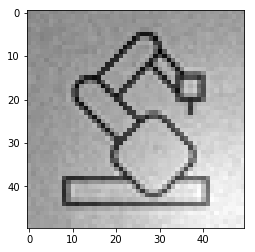

In [10]:
from sklearn.model_selection import train_test_split

X_datasets2 = np.concatenate(X_datasets)
Y_datasets2 = np.concatenate(Y_datasets)
print("Total samples number:",X_datasets2.shape)
X_trains,X_tests,Y_trains,Y_tests = train_test_split(X_datasets2,Y_datasets2,test_size=0.25)
print("Samples for tests:",Y_tests.shape[0])
print("Samples for trains:",Y_trains.shape[0])
plt.imshow(X_tests[0],cmap='gray')

In [11]:
# Create first network with Keras
from keras.models import Sequential
from keras.layers import Dense,Activation,Reshape
from keras.callbacks import EarlyStopping,ModelCheckpoint
import numpy

callbacks = [
    EarlyStopping(monitor='val_loss', min_delta=0.00001, verbose=1),
    # EarlyStopping(monitor='val_loss', patience=2, verbose=0),
    ModelCheckpoint(filepath='./weights.net', verbose=1, save_best_only=True),
    
]

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

input_dim = X_trains[0].shape[0]*X_trains[0].shape[1]
print((X_trains[0].shape[0],X_trains[0].shape[1]))
print(Y_trains[0].shape[0])
# create model
model = Sequential()
model.add(Reshape((input_dim,), input_shape=(X_trains[0].shape[0],X_trains[0].shape[1])))
model.add(Dense(input_dim, input_shape = (input_dim,), init='uniform', activation='relu'))
model.add(Dense(int(input_dim/2), init='uniform', activation='relu'))
model.add(Dense(int(input_dim), init='uniform', activation='relu'))
model.add(Dense(Y_trains[0].shape[0],init='uniform', name="output"))
model.add(Activation('softmax', name="softmax"))
model.summary()

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fit the model
model.fit(X_trains, 
          Y_trains, 
          epochs=10, 
          batch_size=10, 
            )
# calculate predictions
results = model.evaluate(X_tests, Y_tests, batch_size=32, verbose=1, sample_weight=None)
# round predictions
print(results)

(50, 50)
4
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 2500)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 2500)              6252500   
_________________________________________________________________
dense_5 (Dense)              (None, 1250)              3126250   
_________________________________________________________________
dense_6 (Dense)              (None, 2500)              3127500   
_________________________________________________________________
output (Dense)               (None, 4)                 10004     
_________________________________________________________________
softmax (Activation)         (None, 4)                 0         
Total params: 12,516,254
Trainable params: 12,516,254
Non-trainable params: 0
_____________________________________________________

/Users/nadira/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:24: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2500, activation="relu", kernel_initializer="uniform", input_shape=(2500,))`
/Users/nadira/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:25: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1250, activation="relu", kernel_initializer="uniform")`
/Users/nadira/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:26: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(2500, activation="relu", kernel_initializer="uniform")`
/Users/nadira/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:27: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(4, kernel_initializer="uniform", name="output")`


Epoch 1/10
1575/1575 [==============================] - 33s 21ms/step - loss: 0.3424 - acc: 0.8711
Epoch 2/10
1575/1575 [==============================] - 36s 23ms/step - loss: 0.2250 - acc: 0.9162
Epoch 3/10
1575/1575 [==============================] - 36s 23ms/step - loss: 0.1654 - acc: 0.9371 3s - loss: 0.1629
Epoch 4/10
1575/1575 [==============================] - 35s 22ms/step - loss: 0.1119 - acc: 0.9562
Epoch 5/10
1575/1575 [==============================] - 32s 20ms/step - loss: 0.1402 - acc: 0.9610
Epoch 6/10
1575/1575 [==============================] - 32s 20ms/step - loss: 0.1238 - acc: 0.9584
Epoch 7/10
1575/1575 [==============================] - 33s 21ms/step - loss: 0.0702 - acc: 0.9737
Epoch 8/10
1575/1575 [==============================] - 32s 21ms/step - loss: 0.0635 - acc: 0.9784
Epoch 9/10
1575/1575 [==============================] - 32s 20ms/step - loss: 0.0557 - acc: 0.9832
Epoch 10/10
526/526 [==============================] - 1s 1ms/step
[0.36438504923595394, 0.